# Assignment based on Tutorial II: Fully connected NNs
<p>
AICP, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>
This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Test B: Two-Layer Model (Baseline) with On-the-Fly Single Data Augmentation (random affine shifts) (corrected)

Baseline Model (2-layer NN) 1500 neurons in first hidden layer with ReLU activation, 10 neurons in output layer with softmax activation, learning rate 0.001, 10 epochs, batch size 64.


## 1. Load necessary libraries



In [1]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader 


## 2. Structure of a neural network

In [2]:
#Class Definition and Initialization
class MyModel(nn.Module):
    def __init__(self, n_input, n_hiddens, n_output): 
        super(MyModel, self).__init__()
   
        self.ls = []
        n_prev = n_input
        for i, n_out in enumerate(n_hiddens):
          l = nn.Linear(n_prev, n_out) 
          n_prev = n_out 
          self.add_module(f'lin_{i}_{n_out}', l) 
          self.ls.append(l) 

        self.lout = nn.Linear(n_prev, n_output) 

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)       
        h = x 
        for li in self.ls:  
          h = li(h) 
          h = torch.relu(h) 
          
        logits = self.lout(h)
        probs = F.softmax(logits, dim=1) 
        pred = torch.argmax(probs, dim=1) 

        return logits, probs, pred
     

## 3. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

Note: The images are originally 28x28 pixels. Since a neural network expects a flat array of features (a 1D vector), each 28x28 image needs to be transformed into a 1D array of 784 elements (since 28×28=784).

In [3]:
#data transformation pipeline
transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # applying on-the-fly single data augmentation (random affine shifts)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])
                                
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [4]:
#Looping Over the Dataset
for el in trainset:
  x, y = el
  print(x.shape, y)
  break

torch.Size([1, 28, 28]) 9


In [5]:
for el in trainloader:
  x, y = el 
  print(x.shape, y.shape) 
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [6]:
model = MyModel(n_input=784, n_hiddens=[1500], n_output=10)  

In [7]:
# Function to get the number of parameters
def get_npars(model):
    """
    Returns the total number of trainable parameters in the given PyTorch model.
    """
    n = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    return int(n)

# Get and print the number of parameters in the model
num_parameters = get_npars(model)
print(f'The model has {num_parameters} trainable parameters.')


The model has 1192510 trainable parameters.


In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Defining a training function:

In [9]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  
        output, _, _ = model(images) 
        loss = criterion(output, labels) 
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() 
    return running_loss / len(trainloader) 


Defining a testing function:

In [10]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    n_samples = 0  

    with torch.no_grad(): 
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels) 
            running_loss += loss.item()

            correct = torch.sum(pred == labels) 
            n_correct += correct.item()  
            n_samples += labels.size(0) 

    accuracy = n_correct / n_samples  # Compute overall accuracy
    return running_loss / len(testloader), accuracy

In [11]:
testloader.batch_size

64

Training the model

In [12]:
# Lists to store losses and accuracy for Test B model
train_losses_testB = []
test_losses_testB = []
test_accuracies_testB = []  

num_epochs = 10 # Number of epochs for training

for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss, test_accuracy = test(model, testloader, criterion)  # Assuming test returns loss and accuracy

   # Store losses for Test B model
    train_losses_testB.append(train_loss)
    test_losses_testB.append(test_loss)

     # Store accuracy for TestB model
    test_accuracies_testB.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.6913, Test Loss: 0.6428, Test Accuracy: 0.7472
Epoch 2/10, Train Loss: 0.5563, Test Loss: 0.5583, Test Accuracy: 0.7929
Epoch 3/10, Train Loss: 0.5152, Test Loss: 0.5492, Test Accuracy: 0.8055
Epoch 4/10, Train Loss: 0.4850, Test Loss: 0.4955, Test Accuracy: 0.8172
Epoch 5/10, Train Loss: 0.4691, Test Loss: 0.4899, Test Accuracy: 0.8233
Epoch 6/10, Train Loss: 0.4532, Test Loss: 0.4748, Test Accuracy: 0.8322
Epoch 7/10, Train Loss: 0.4466, Test Loss: 0.4664, Test Accuracy: 0.8313
Epoch 8/10, Train Loss: 0.4387, Test Loss: 0.4743, Test Accuracy: 0.8289
Epoch 9/10, Train Loss: 0.4305, Test Loss: 0.4596, Test Accuracy: 0.8352
Epoch 10/10, Train Loss: 0.4230, Test Loss: 0.4593, Test Accuracy: 0.8369


Visualize the loss curves

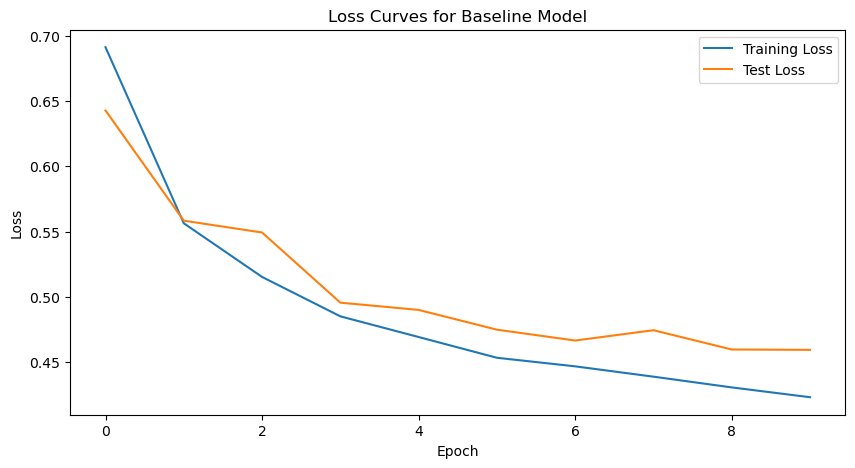

In [13]:
# Plotting the loss curves for the Test B model
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses_testB, label='Training Loss')
ax.plot(range(num_epochs), test_losses_testB, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.set_title('Loss Curves for Baseline Model')
plt.show()

In [14]:
for p in model.parameters():
  print(np.prod(list(p.shape)))

1176000
1500
15000
10


In [15]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.841


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 11


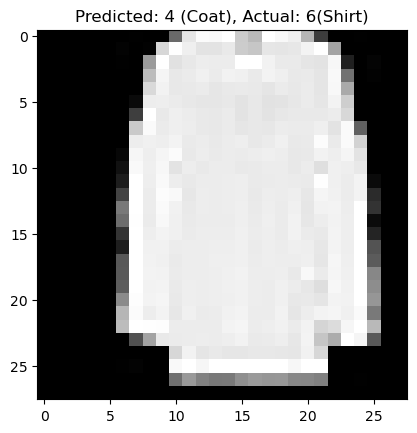

First correct digit is at index: 0


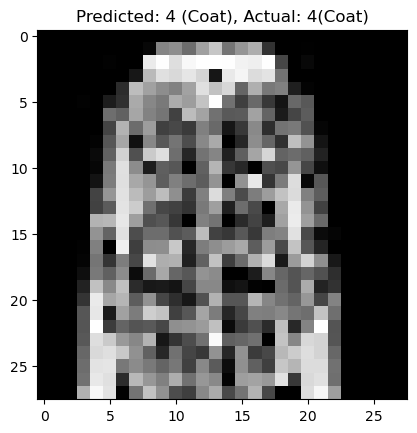

In [16]:
# Get the class names from the dataset
class_names = trainset.classes

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect sample (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    pred = predictions[wrong_idx]
    lbl  = labels[wrong_idx]
    display_image(images_list[wrong_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No incorrect predictions found")

# Display the first correct sample (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    pred = predictions[correct_idx]
    lbl  = labels[correct_idx]
    display_image(images_list[correct_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

torch.Size([10, 1500]) torch.Size([10])


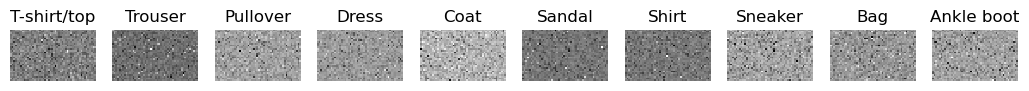

In [17]:
#inspecting and visualising the weights of the output layer
layer = model.lout 
n_features = layer.out_features 
w1, b1 = layer.weight.data, layer.bias.data #extract weights and biases from the output layer.
print(w1.shape, b1.shape) ## expecting w1 to be [n_features, 1500]

w1_reshaped = w1.view(n_features, 30, 50) #Adjust the view dimensions as per layer's configuration of 1500 neurons

# Plotting the weights
_, axs = plt.subplots(1, n_features, figsize=(13, 5))

for i in range(10): # Loop over the number of output features (classes)
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='gray', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title(f'{trainset.classes[i]}')
plt.show()

In [18]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, probs, pred = model(images)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy



In [19]:
#generate predictions and compute the final accuracy after training the model
predictions, labels, images_list = get_predictions(model, testloader)  
accuracy = calculate_accuracy(predictions, labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8368


In [20]:
import datetime

# Get the current date and time for unique naming
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the filename using only the test name (will overwrite with each run)
test_name = "testB"  # Replace with your test name
model_filename = f'{test_name}_trained_model.pth'

# Save the model and optimizer state dicts
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_losses_testB,
    'test_loss': test_losses_testB
}

torch.save(save_dict, model_filename)  # Add this line to actually save the dictionary
print(f'Trained model saved as {model_filename}')


Trained model saved as testB_trained_model.pth


In [21]:
# Code for Storing Results in JSON Files
import json

# Store the results (losses and accuracy) in a dictionary
results = {
    'train_losses': train_losses_testB,  
    'test_losses': test_losses_testB,    
    'test_accuracies': test_accuracies_testB, 
    'final_accuracy': accuracy  # Store the final accuracy calculated earlier
}

# Save results to a JSON file, overwrite each time
json_filename = f'{test_name}_results.json'  # No timestamp to allow overwriting
with open(json_filename, 'w') as f:
    json.dump(results, f)
print(f'Results saved in {json_filename}')


Results saved in testB_results.json
